### Display some pictures

In [1]:
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)


# import scipy as sio
# print("Scipy Version :"+sio.__version__)
import scipy.io as sio
import os
import shutil
import random
import cv2 as cv
print("OpenCV Version : "+cv.__version__)
from PIL import Image

# To be able to use Warning
import warnings
import sklearn
print("Sklearn Version : "+sklearn.__version__)
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
import catboost
print("Catboost Version : "+catboost.__version__)
from catboost import CatBoostClassifier
# from utils import plot_confusion_matrix

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.0.5
Seaborn Version :0.10.1
OpenCV Version : 3.4.2
Sklearn Version : 0.23.1
Catboost Version : 0.24


Using TensorFlow backend.


Keras Version : 2.2.4-tf
Tensorflow Version : 2.1.0


In [2]:
images_directory = './images/Images/'
# train_contents = sio.loadmat('./lists/train_list.mat')
# test_contents = sio.loadmat('./lists/test_list.mat')
# file_list = sio.loadmat('./lists/file_list.mat')
train_directory = './images/train-tiny/'
test_directory = './images/test/'

In [3]:
input_directory='./images/'
output_directory='./new_images/'
small_directory_names = [directory for directory in os.listdir(input_directory+'train-tiny')]
small_directory_names.sort()
color_mode_parameter='grayscale'
save_prefix_parameter='set1_'
batch_size=2
follow_links=True

In [4]:
small_directory_names

['Basset', 'Cardigan', 'OldEnglishSheepdog']

In [5]:
myCategories = dict(enumerate(small_directory_names))

In [6]:
myCategories

{0: 'Basset', 1: 'Cardigan', 2: 'OldEnglishSheepdog'}

In [7]:
train_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

### Compute the descriptors  and add them with the category into a dataframe

In [8]:
algo_constructor = cv.xfeatures2d.SIFT_create()
def computeDescriptors(mygenerator, mydf, mydescriptors):
    count = 0
    for i in range(len(mygenerator)):
    #next(train_generator)
        for j in range(batch_size):
            img = mygenerator[i][0][j].squeeze()
            imgwithrgb = cv.merge([img, img, img])
            image8bit = cv.normalize(imgwithrgb, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
            keypoints, descriptors = algo_constructor.detectAndCompute(image8bit, None)
            mydf = mydf.append({'Category': mygenerator[i][1][j].tolist().index(1), 'Picture':image8bit, 'Descriptors':descriptors, 'NumberOfDescriptors':descriptors.shape[0]}, ignore_index='True')
            mydescriptors.extend(descriptors)
            count = count + 1
            j = j+1
    i = i+1
    mydf['Category'] = mydf['Category'].map(myCategories) 
    return mydf, mydescriptors

### Train 

In [9]:
def displayPictures(mytrain_df, whitening_flag, std_flag):
    fig, axs = plt.subplots(1, 5, figsize=(60, 12))
    axs[0].set_title('An original picture  ', fontsize=20)
    # img = cv.imread(input_directory+'train-tiny'+'/Basset/n02088238_13908.jpg')
    img = cv.imread(input_directory+'train-tiny'+'/Basset/n02088238_8140.jpg')
    RGB_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axs[0].imshow(RGB_img)
    axs[1].hist(RGB_img.ravel(), 256, [0, 256])
    axs[1].set_title('Histogram of an original picture  ', fontsize=20)
    axs[1].set_xlabel('Level of gray', fontsize=20)
    axs[1].set_ylabel('Number of pixels', fontsize=20)
    axs[2].set_title('A tranformed picture in grayscale with Whitening to '+ (str)(whitening_flag) + ' Standardisation ' + (str)(std_flag), fontsize=20)
    axs[2].imshow(mytrain_df['Picture'][1], cmap='Greys_r')
    axs[3].set_title('Histogram of a tranformed picture in grayscale with Whitening to '+ (str)(whitening_flag) + ' Standardisation ' + (str)(std_flag), fontsize=20)
    axs[3].set_xlabel('Level of gray', fontsize=20)
    axs[3].set_ylabel('Number of pixels', fontsize=20)
    axs[3].hist(mytrain_df['Picture'][1].ravel(), 256, [0, 256])
    axs[4].set_title('Key Features of the transformed picture ', fontsize=20)
    kp, desc = algo_constructor.detectAndCompute(mytrain_df['Picture'][1],None)
    imgwithfeatures = cv.drawKeypoints(mytrain_df['Picture'][1],kp, None)
    axs[4].imshow(imgwithfeatures, cmap='Greys_r')


In [10]:
def computeanddisplaypicture(whitening_flag, std_flag):
    mytrain_datagen = ImageDataGenerator(
        rescale=1./255,
        zca_whitening=whitening_flag,
        featurewise_std_normalization=std_flag
        )
    mytrain_generator = mytrain_datagen.flow_from_directory(input_directory+'train-tiny', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, subset='training', shuffle=False, color_mode=color_mode_parameter) 
    mytrain_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])
    mytrain_descriptors_array=[]
    mytrain_df, mytrain_descriptors_array=computeDescriptors(mytrain_generator, mytrain_df, mytrain_descriptors_array)
    displayPictures(mytrain_df, whitening_flag, std_flag)

Found 6 images belonging to 3 classes.


/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '
/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:348: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewi

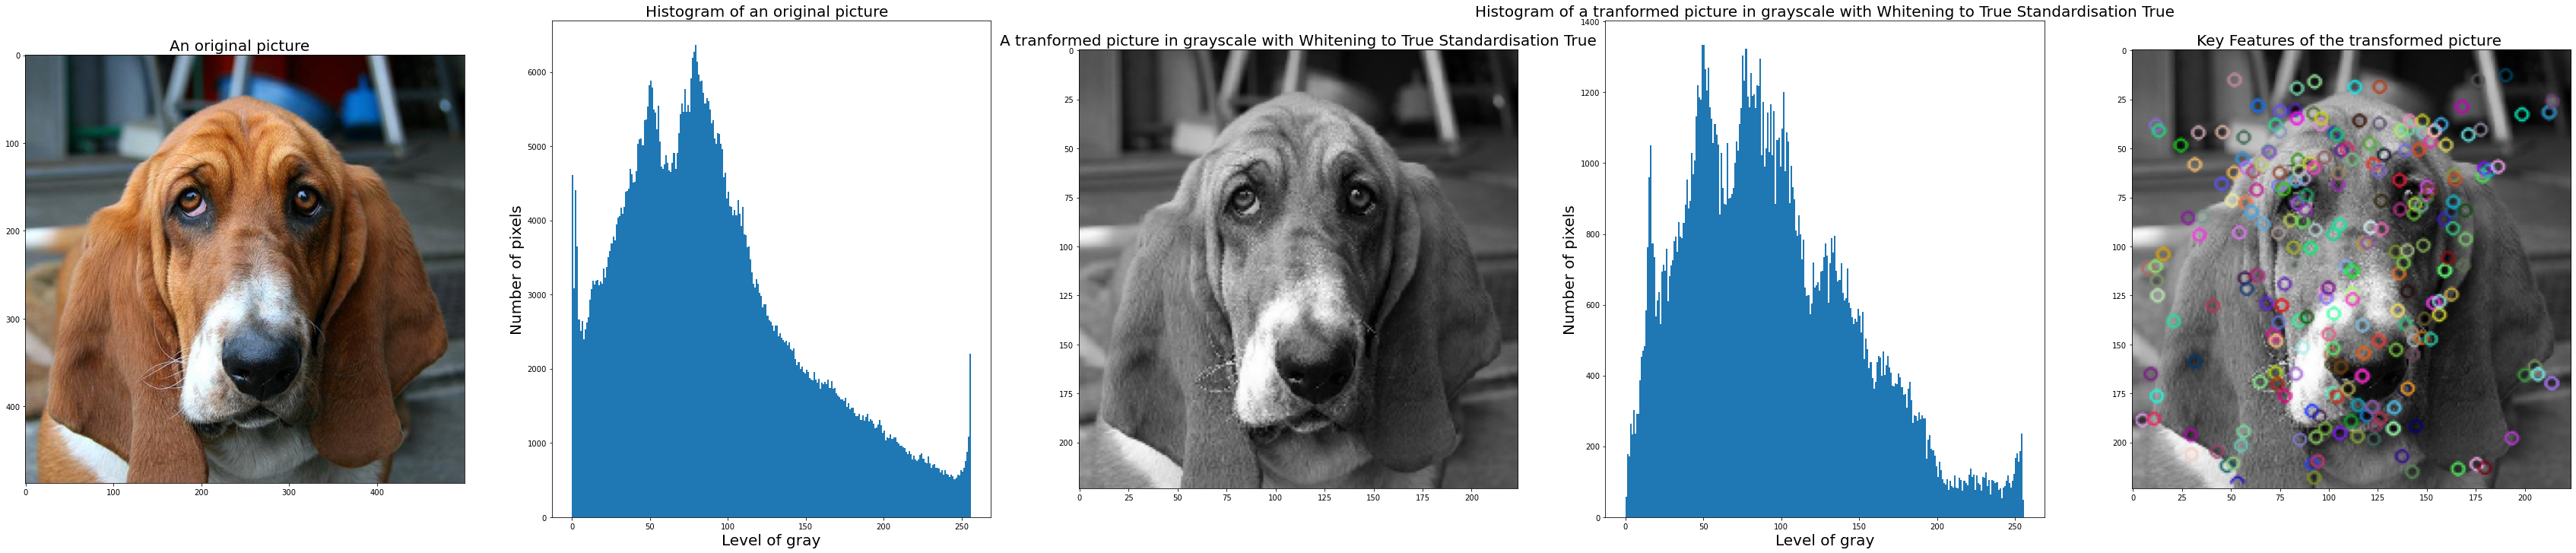

In [11]:
computeanddisplaypicture(whitening_flag=True, std_flag=True)

Found 6 images belonging to 3 classes.


/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


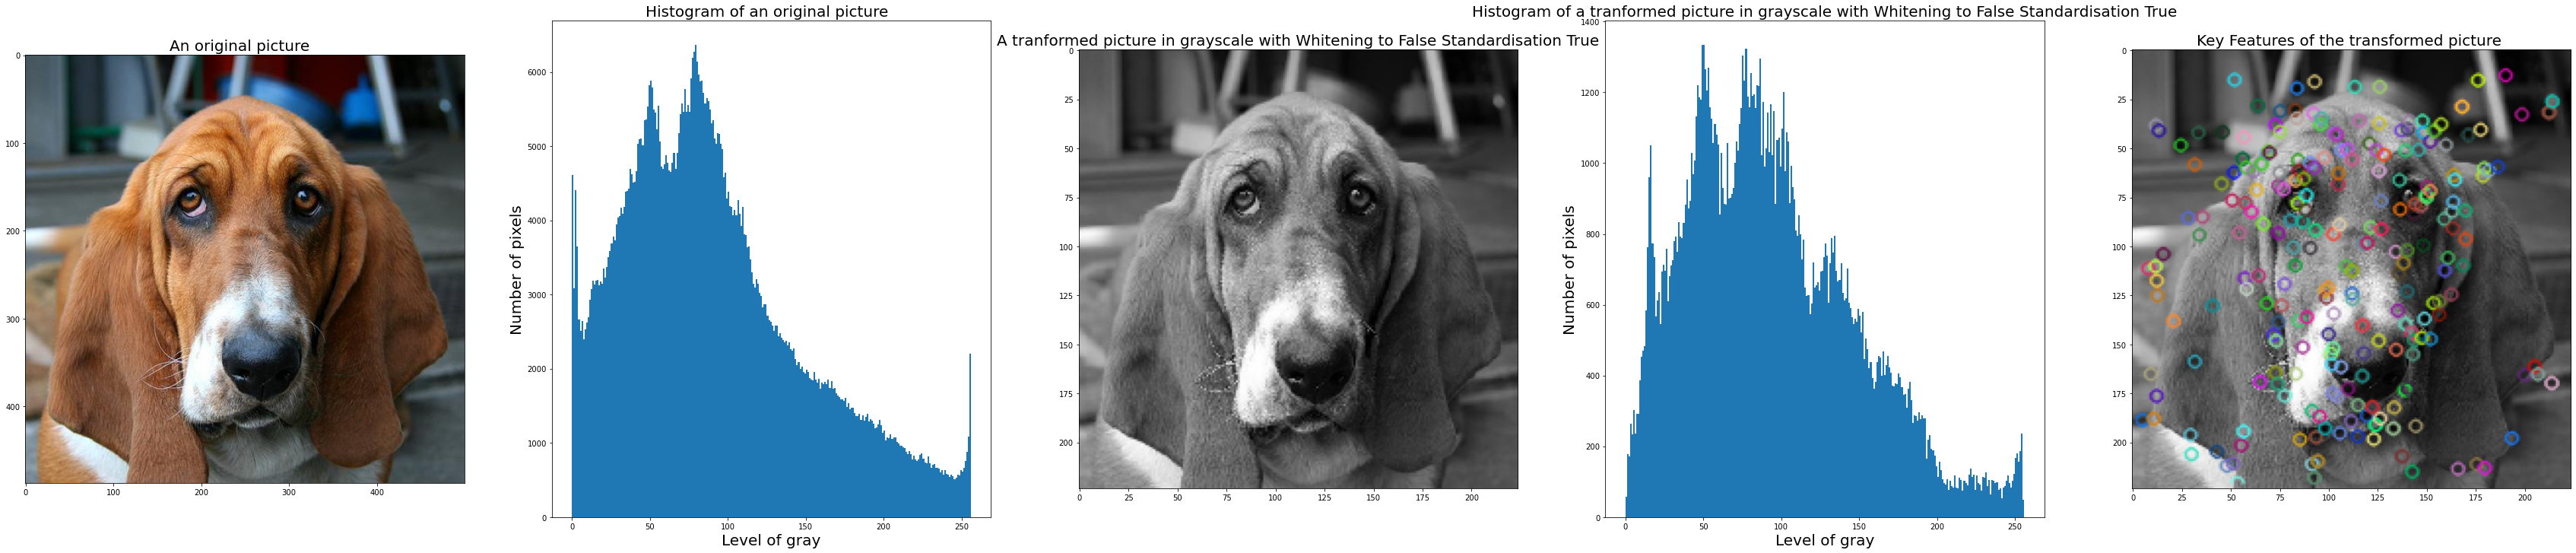

In [12]:
computeanddisplaypicture(whitening_flag=False, std_flag=True)

Found 6 images belonging to 3 classes.


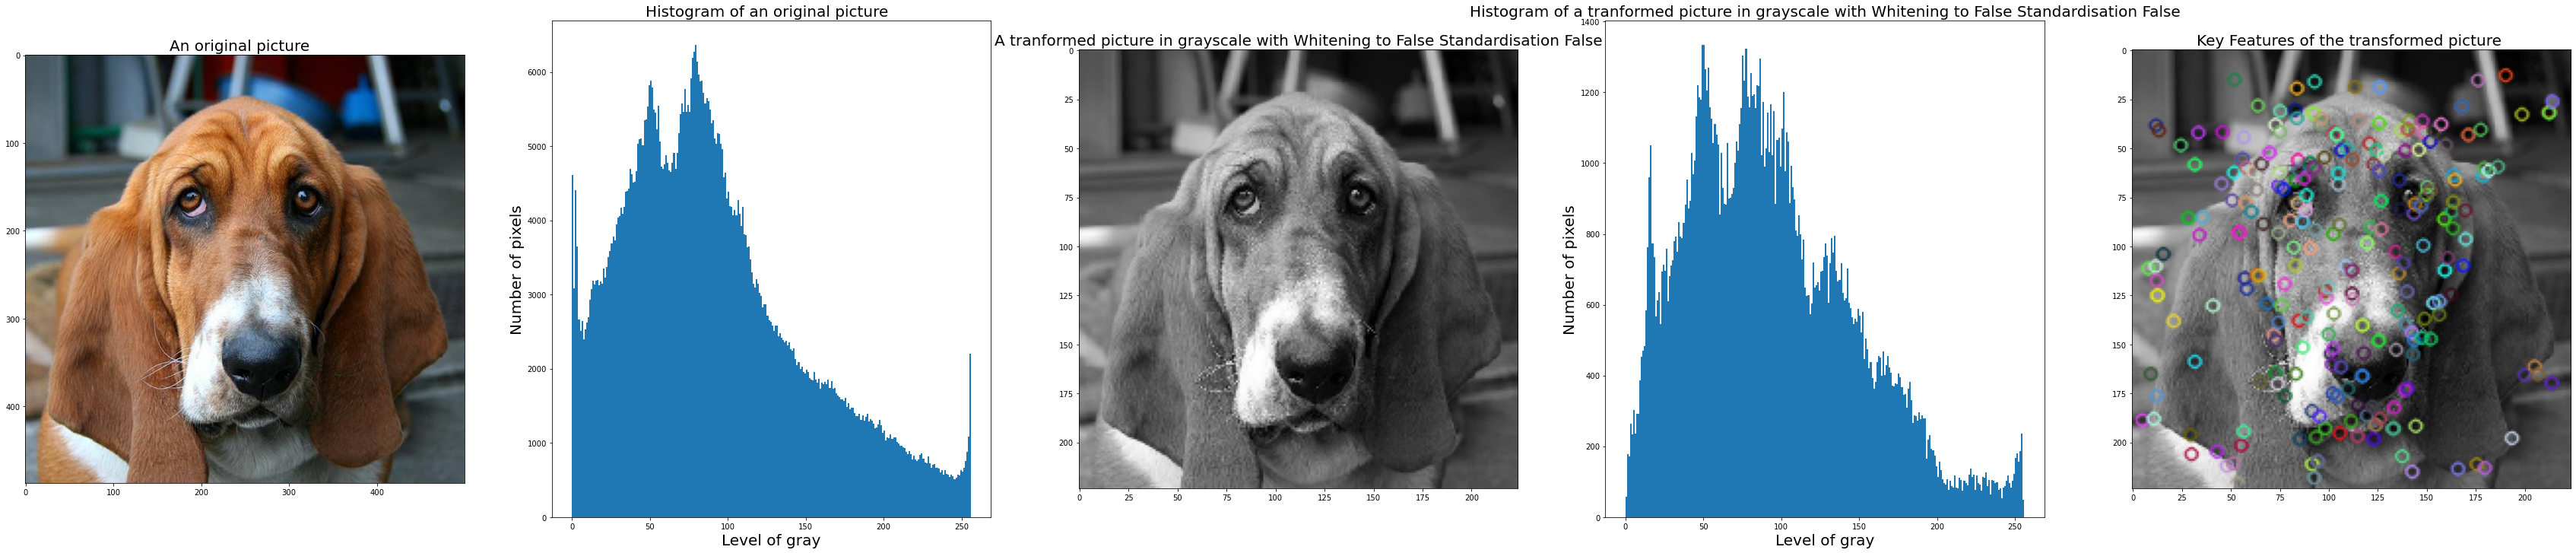

In [13]:
computeanddisplaypicture(whitening_flag=False, std_flag=False)

Found 6 images belonging to 3 classes.


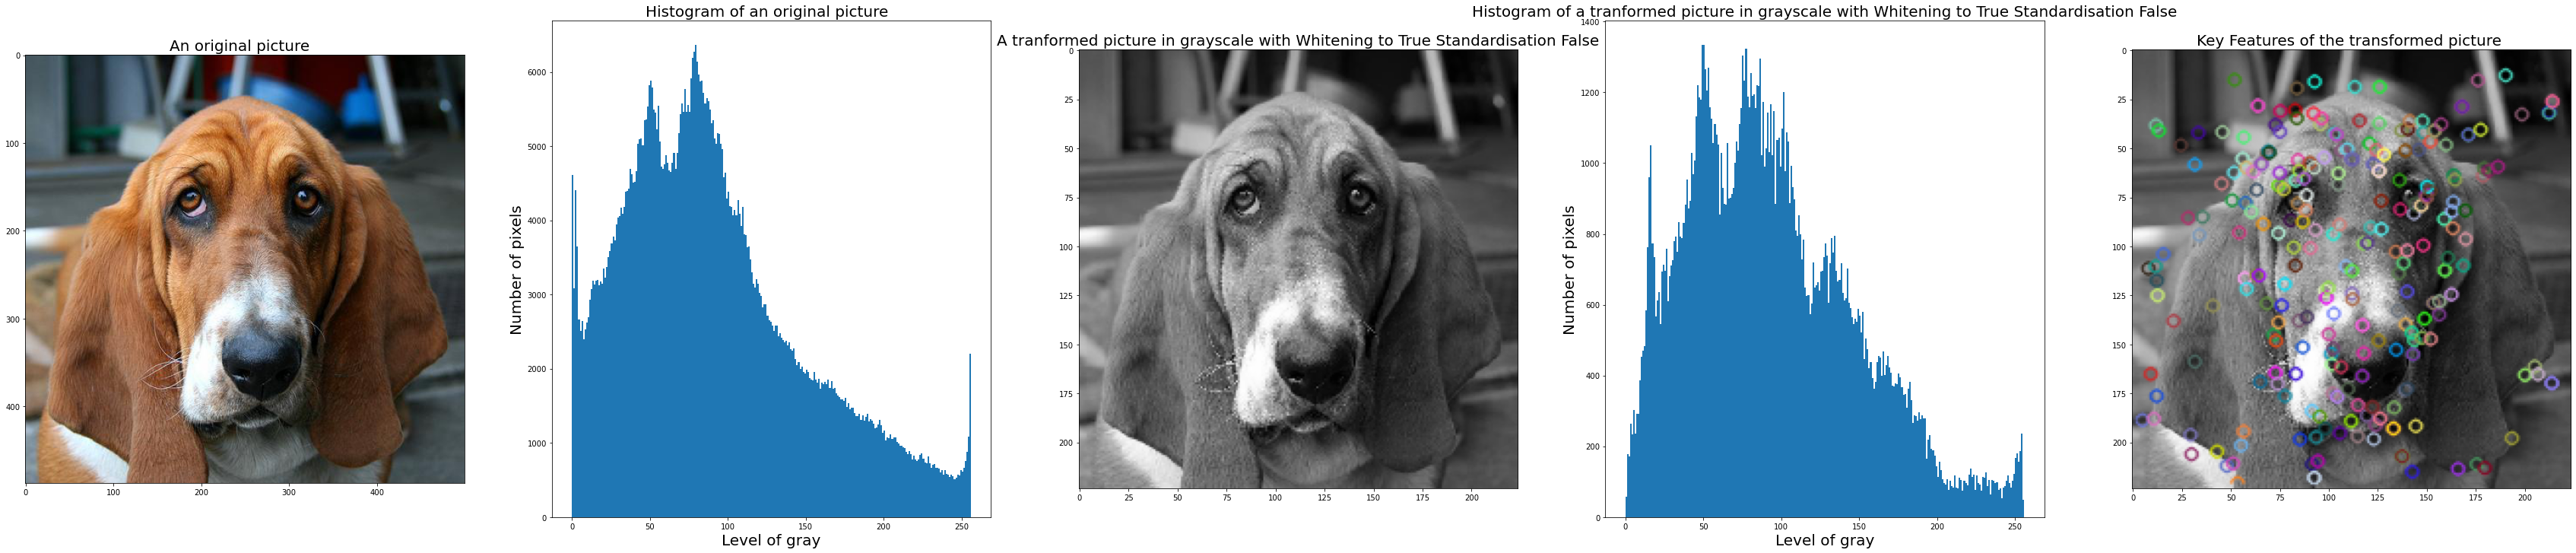

In [14]:
computeanddisplaypicture(whitening_flag=True, std_flag=False)

In [15]:
transformation_ratio = .05
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=transformation_ratio, shear_range=transformation_ratio, zoom_range=transformation_ratio, cval=transformation_ratio, horizontal_flip=True, vertical_flip=True, validation_split=0.2)

In [16]:
train_generator = train_datagen.flow_from_directory(train_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=small_directory_names, subset='training')

Found 6 images belonging to 3 classes.


In [35]:
X_batch, Y_batch =  next(train_generator)

In [38]:
img = load_img(train_directory +  '/OldEnglishSheepdog/n02105641_3499.jpg')

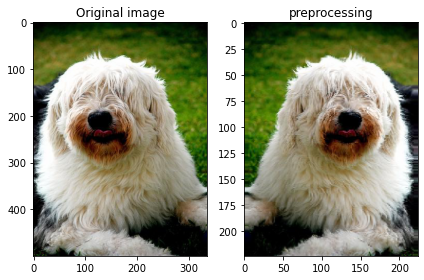

In [40]:

plt.subplot(1, 2, 1)
plt.imshow(img, aspect="auto")
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(X_batch[0], aspect="auto")
plt.title('preprocessing')
plt.tight_layout()
plt.show()